<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h2 align="left"><font color=Purple>Traditional Recommendation Systems</font></h2>

<br>
<br>
    
<img src="./charts/re.png" width="700">
<br>    
<br>
      
<h2 align="left"><font color=Purple>A Learning to Rank Recommendation System</font></h2>
    
<br>    
<br> 
    
In this work, we propose a Learning to Rank Recommender System leveraging the advances of NLP and information retrieval techniques.
    
  
<br>

Here are the steps we take to develop our recommender system:
    

   
- **Data Cleaning & Transformation:** Cleans the dataset by handling missing values, duplicates, and outliers, and later preparing the entire data for effective feature engineering.

   
- **Feature Engineering:**  Develops new features based on the transactional data to create a customer-centric dataset which essentially describes users' behaviours.

   
- **Data Exploration & Preprocessing:**  Undertakes visual exploration on numerical and categorical features, and later provides text cleaning on product descriptions collected for each customer.


- **Text to Vector:**  Applies TF-IDF and Word2vec to textual descriptions on the products that have been purchased by customers. Word2vec indeed encodes a compact d-dimensional vector representation for each customer in the dataset.


- **Buiding Final Embeddings & Quality Assessment:**  Concatenates behavior features with learnt embeddings on each customer. K-means clustering and TSNE visualization are applied to the concatenated vectors to reveal the quality compact features.

   
- **Learning to Rank & Evaluation:** Follows the pair-wise learning to rank approach which generates a list  relevance scores for products based on  LambdaMART (Multiple Additive Regression Trees). If we sort the list of relevance scores, the top-N scores belongs to highly recommended products. As an evaluation metric, we report on NDCG score. 



In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import random
import nltk
import re

#nltk.download('stopwords')
#from nltk.tokenize import word_tokenize
#nltk.download('words')
%matplotlib inline

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

The dataset consists of 541,909 entries and 8 columns. Here is a quick overview of each column:

- **InvoiceNo:** This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction. The invoice numbers start with C are the cancelled transactions.
   
    
- **StockCode:** An object data type column representing the product code for each item. 

    
- **Description:** This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.

    
- **Quantity:** This is an integer column indicating the quantity of products purchased in each transaction.
   
    
- **InvoiceDate:** A datetime column that records the date and time of each transaction.
    
    
- **UnitPrice:** A float column representing the unit price of each product.

    
- **CustomerID:** A float column that contains the customer ID for each transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.

  
- **Country:** An object column recording the country where each transaction took place.


In [2]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=Purple>Data Cleaning & Transformation </font></h3>
   
We clean the data in the following steps:

- **Handling Missing values:** By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving an effective recommendation system.
   
   
- **Handling Duplicates:** We remove identical rows, including identical transaction times, suggesting that these might be data recording errors not intentionally repeated transactions.
   
   
- **Detecting Negative Values:**  The negative values on unit price indicate returned or cancelled orders, which need to be removed appropriately.

   
- **Detecting Wrong Values:** The stock codes seem to represent non-product transactions like 'POST', 'D', 'C2', 'M', 'PADS', 'DOT', 'CRUK', which will be omitted in the dataset.

   
- **Outlier Treatment:** There are around 5% outliers on Unit price and quantity that need to be treated.


### Missing values

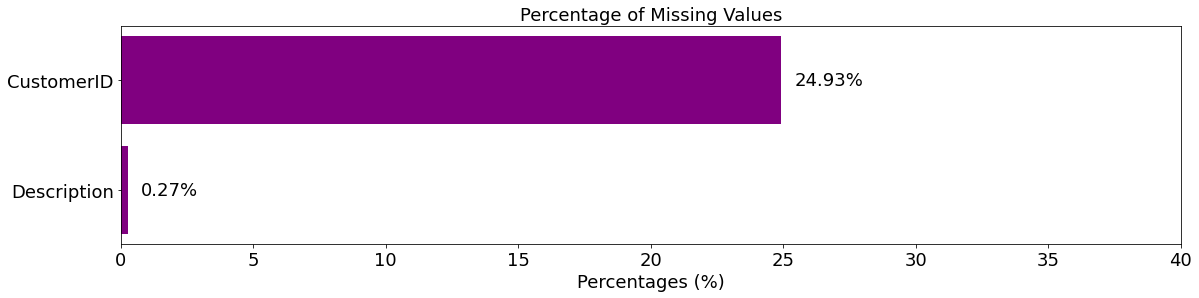

In [5]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(19, 4))
ax.barh(missing_percentage.index, missing_percentage, color='Purple')
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontsize=18, color='black')

ax.set_xlim([0, 40])
ax.tick_params(axis='both',labelsize=18)
plt.title("Percentage of Missing Values", fontsize=18)
plt.xlabel('Percentages (%)', fontsize=18)
plt.show()

In [6]:
print('Number of cancelled transactions:', len([ i for i  in df['InvoiceNo'] if str(i).startswith('C')]))

Number of cancelled transactions: 9288


In [7]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns

df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [8]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

### Removing duplicates 

In [9]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [10]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [11]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

In [12]:
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["StockCode"] = df["StockCode"].astype(str)
df["Description"] = df["Description"].astype(str)
df["Quantity"] = df["Quantity"].astype(int)
df["CustomerID"] = df["CustomerID"].astype(int)
df["UnitPrice"] = df["UnitPrice"].astype(float)
df["Country"] = df["Country"].astype(str)

In [13]:
print([v for v in df['CustomerID'].unique() if len(str(v))<4])

[]


In [14]:
# check wrong values

print([v for v in df['StockCode'].unique() if len(v)<=4])

['POST', 'D', 'C2', 'M', 'PADS', 'DOT', 'CRUK']


In [15]:
df.drop(df[(df.StockCode =='DOT')|( df.StockCode =='D')| (df.StockCode =='#')| 
           (df.StockCode =='POST')|( df.StockCode =='PADS') |( df.StockCode =='CRUK')|
           (df.StockCode =='C2')| (df.StockCode =='M')|(df.StockCode =='BANK CHARGES')].index, inplace=True)

In [16]:
# Getting the number of rows in the dataframe
df.shape

(399689, 8)

In [17]:
df[["Quantity", "UnitPrice"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,399689.0,12.229383,250.836859,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,399689.0,2.907457,4.451881,0.0,1.25,1.95,3.75,649.5


In [18]:
#Now lets check what is in negative quantity

df[df["Quantity"]<=0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


In [19]:
#Remove negative values in colmn 'Quantity'
df_new= df.copy()
df_new= df_new[(df_new['Quantity'] >= 0)]
df_new= df_new[(df_new['UnitPrice'] >=0)]

In [20]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [21]:
df_new['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")
df_new['Year'] = df_new.InvoiceDate.dt.year
df_new['Month'] = df_new.InvoiceDate.dt.month
df_new['Day']=(df_new.InvoiceDate.dt.dayofweek)+1 # +1 to make Monday=1.....until Sunday=7
df_new['Hour'] = df_new.InvoiceDate.dt.hour
df_new['Total_Spend'] = df['Quantity'] * df['UnitPrice']
df_new.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,Total_Spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,3,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,3,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,3,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,3,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,3,8,20.34


In [22]:
Cust2Country={}

for idx, cy in zip(df_new["CustomerID"].values, df_new["Country"].values):
    Cust2Country[idx]=cy   


### Outlier inspecting

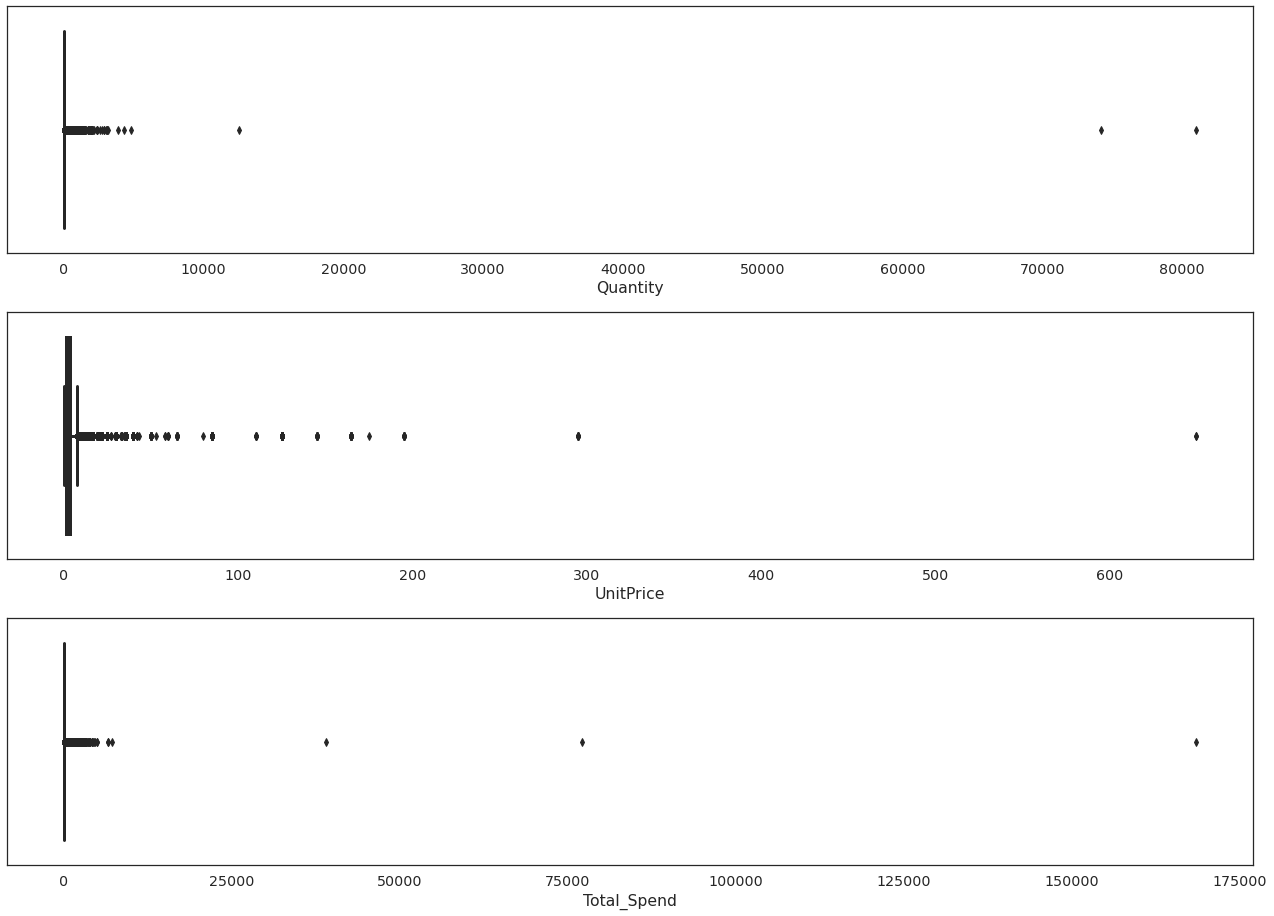

In [23]:
sns.set(font_scale=1.3)  
sns.set_style("white")

kwargs = dict(hist_kws={'alpha':.8}, kde_kws={'linewidth':3})

fig, axes = plt.subplots(3, 1, figsize=(18, 13))

#plt.title('Box Charts') 
sns.boxplot(ax=axes[0], data=df_new, x='Quantity', linewidth=3,saturation=0.9, color= 'Purple')
sns.boxplot(ax=axes[1], data=df_new, x='UnitPrice', linewidth=3,saturation=0.9, color= 'Purple')
sns.boxplot(ax=axes[2], data=df_new, x='Total_Spend', linewidth=3,saturation=0.9, color= 'Purple')

fig.tight_layout() 


plt.show()

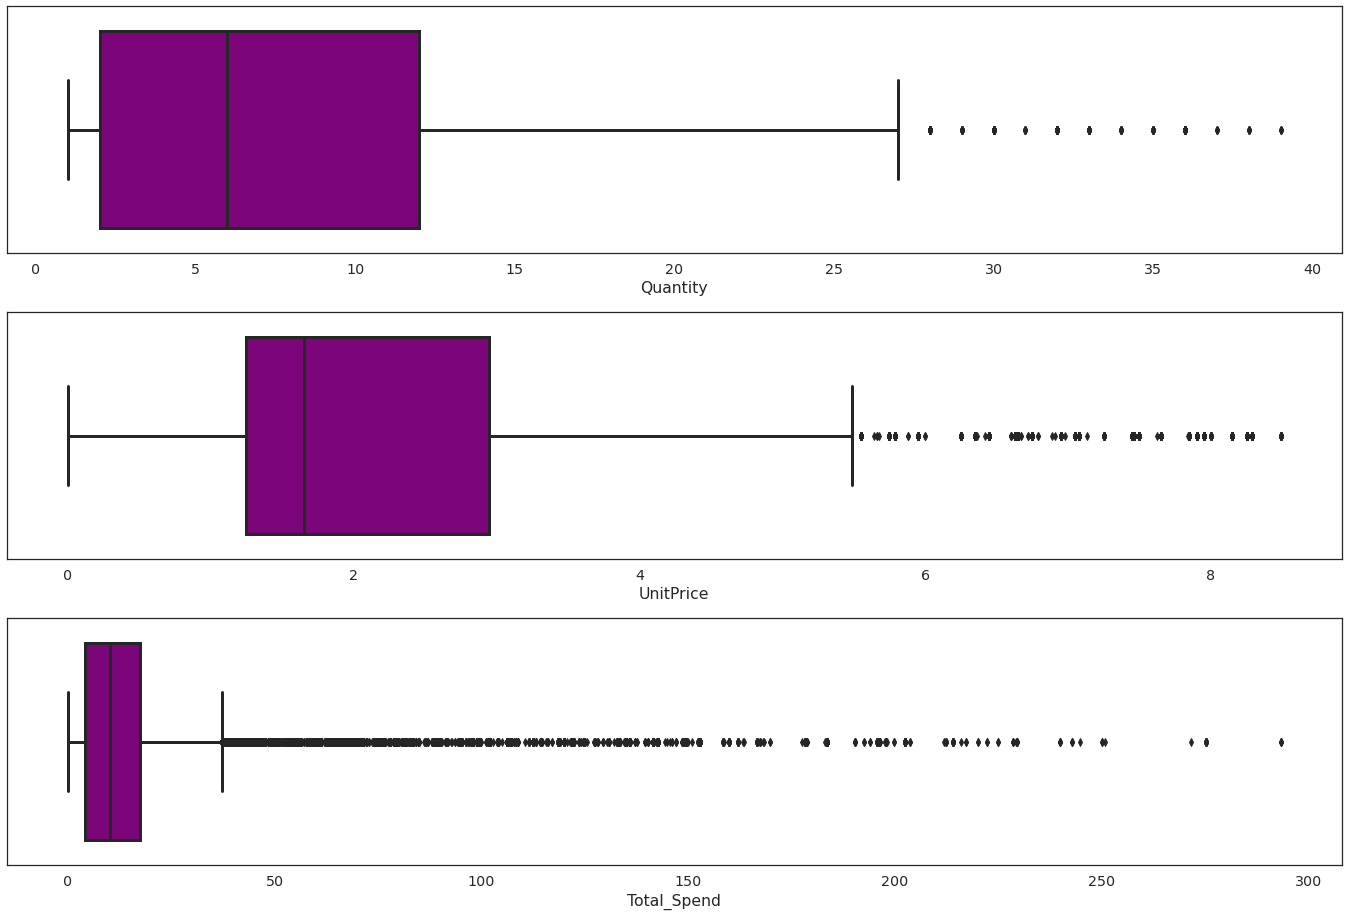

In [24]:
upper_quartile2= df_new.Quantity.quantile(0.95)
df_new= df_new[df_new.Quantity < upper_quartile2]

upper_quartile3= df_new.UnitPrice.quantile(0.95)
df_new= df_new[df_new.UnitPrice < upper_quartile3]

df_new['Total_Spend'] = df['Quantity'] * df['UnitPrice']

fig, axes = plt.subplots(3, 1, figsize=(19, 13))
sns.boxplot(ax=axes[0], data=df_new, x='Quantity', linewidth=3,saturation=0.9, color= 'Purple')
sns.boxplot(ax=axes[1], data=df_new, x='UnitPrice', linewidth=3,saturation=0.9, color= 'Purple')
sns.boxplot(ax=axes[2], data=df_new, x='Total_Spend', linewidth=3,saturation=0.9, color= 'Purple')

fig.tight_layout() 

plt.show()

In [25]:
df_new.shape

(350531, 13)

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=Purple>Data Exploration & Preprocessing </font></h3>
    
 Here we get some insight into the data and  build the required user-specific features:

- **Exploring Features:** We look into values presented by columns visually in depth. Which products were sold the most. Which day of the week or which hour in a day had the highest purchase. People in which country spend more on the company products.
   
   
- **Building New Features:** In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data:
 
    - **Days Since Last Purchase:** This feature represents the number of days that have passed since the customer's last purchase.
   
    - **Total Transactions:** This feature represents the total number of transactions made by a customer.
   
    - **Total Products Purchased:** This feature indicates the total number of products purchased by a customer across all transactions.
   
    - **Total Spend:** This feature represents the total amount of money spent by each customer.
   
    - **Average Transaction Value:** This feature is calculated as the Total Spend divided by the Total Transactions for each customer.
   
    - **Unique Products Purchased:** This feature represents the number of distinct products bought by a customer
   
    - **Average Days Between Purchases:** This feature represents the average number of days a customer waits before making another purchase.

    - **Favorite Shopping Day:** This denotes the day of the week when the customer shops the most.

    - **Favorite Shopping Hour:** This refers to the hour of the day when the customer shops the most.
   
    - **Monthly_Spending_Mean:** This is the average amount a customer spends monthly. It helps us estimate the general spending habits of each customer.
   
    - **Spending_Trend:** This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. 

 ### Best-selling products

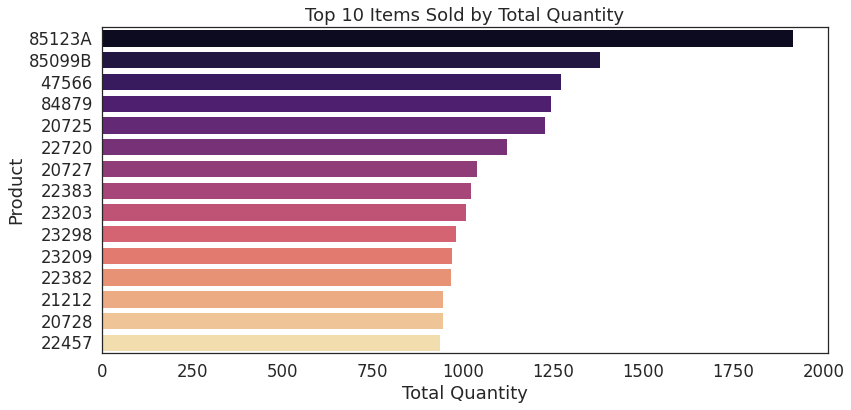

In [26]:
sns.set(font_scale=1.5) 
sns.set_style("white")

df_g= df_new.copy()  

df_vis = df_g.groupby(['StockCode']).size().reset_index(name='Total Quantity')
df_quan_top15 = df_vis.nlargest(15, 'Total Quantity')
plt.figure(figsize=(13, 6))
sns.barplot(data=df_quan_top15, x="Total Quantity", y="StockCode", capsize=1, palette="magma")
plt.title("Top 10 Items Sold by Total Quantity")
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.show()

In [27]:
product_sold ={}
df_stock = df_new.groupby(['StockCode'])['Quantity'].sum().reset_index(name='Total_Sold')
for idx, Qt in (zip(df_stock["StockCode"].values, df_stock["Total_Sold"].values)):
    
    product_sold[str(idx)]= Qt   

### High spender countries 

Text(0.5, 1.0, 'Country vs Total_Spend')

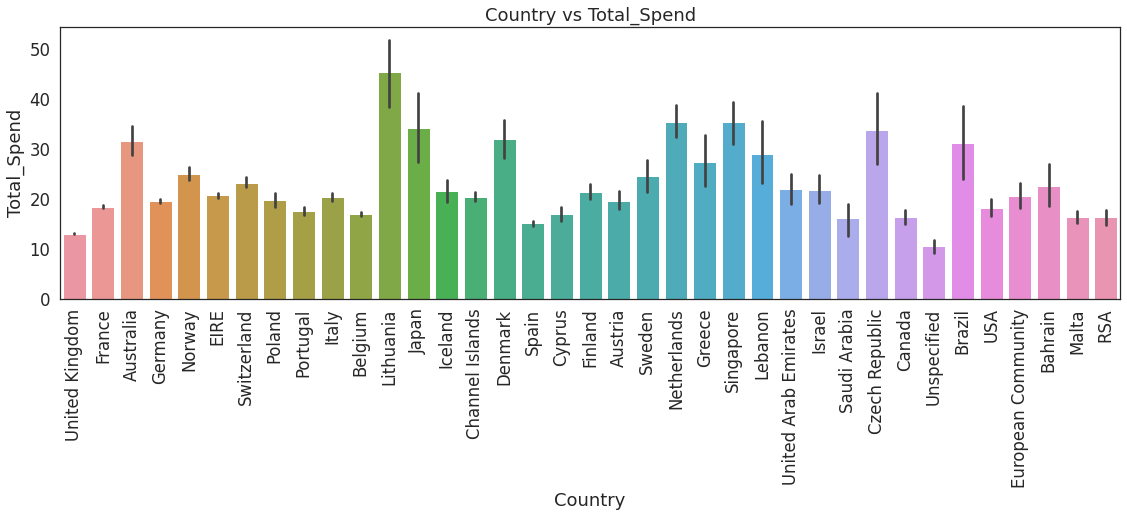

In [28]:
sns.set(font_scale=1.5)  
sns.set_style("white")

plt.figure(figsize=(19,5))

sns.barplot(data = df_new, x="Country", y="Total_Spend")
plt.xticks(rotation=90)
plt.title("Country vs Total_Spend")

### Shopping trend in day and hour

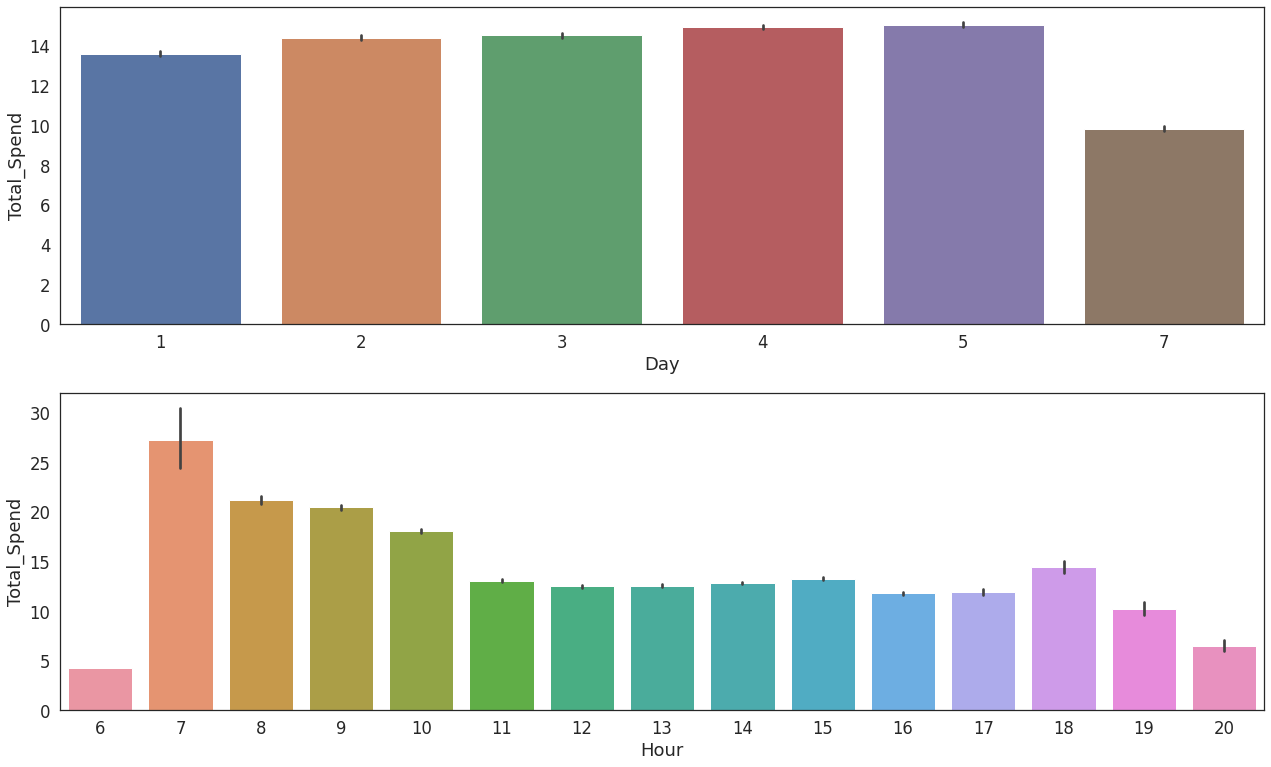

In [29]:
sns.set(font_scale=1.5)  
sns.set_style("white")

fig, axes = plt.subplots(2, 1, figsize=(18, 11))
sns.barplot(ax=axes[0], data = df_new, x="Day", y="Total_Spend")
sns.barplot(ax=axes[1], data = df_new, x="Hour", y="Total_Spend")

fig.tight_layout() 

plt.show()

### Transaction year

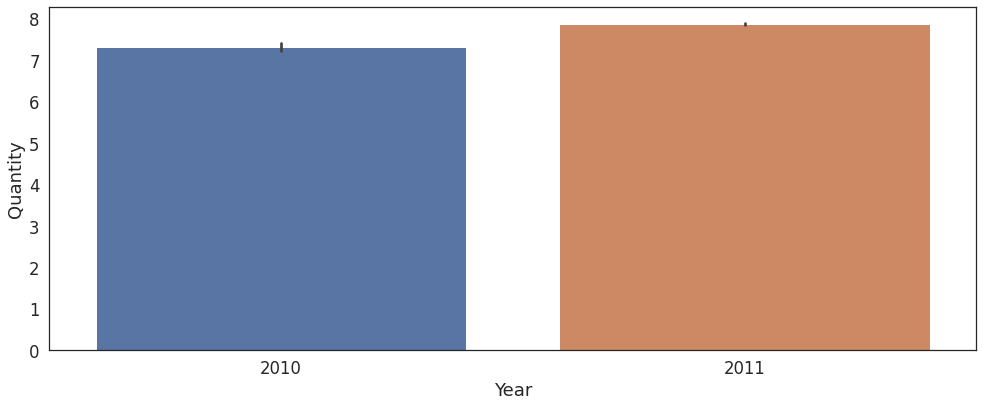

In [30]:
sns.set(font_scale=1.5)  
sns.set_style("white")
fig, axes = plt.subplots(figsize=(14, 6))
sns.barplot( data = df_new, x="Year", y="Quantity")
fig.tight_layout() 
plt.show()

In [31]:
df_new["Country"] = df_new["Country"].astype('category') 
df_new["Year"] = df_new["Year"].astype('category')

df_new["Country"] = df_new["Country"].cat.codes
df_new["Year"] = df_new["Year"].cat.codes

### Positive correlation between total spend and  unit price

<AxesSubplot:xlabel='UnitPrice', ylabel='Total_Spend'>

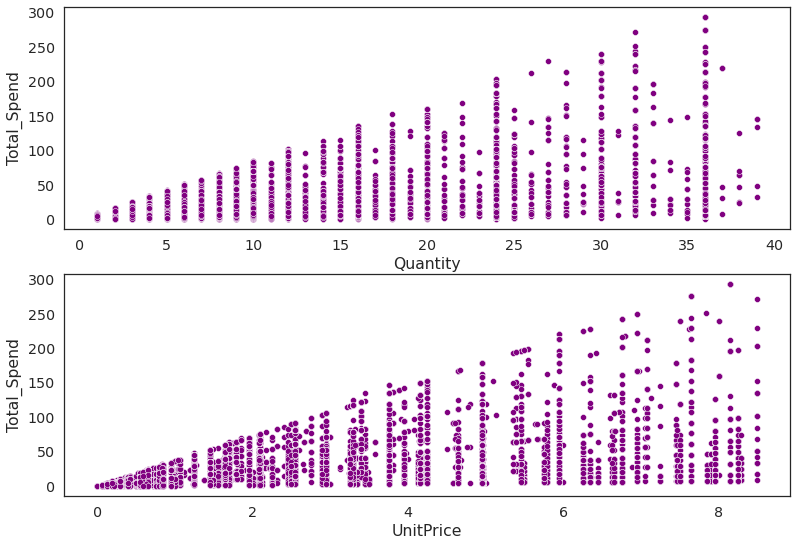

In [32]:
sns.set(font_scale=1.3) 
sns.set_style("white")
fig, axes = plt.subplots(2, 1, figsize=(13,9))

sns.scatterplot(ax=axes[0], data=df_new, x=df_new['Quantity'], y=df_new['Total_Spend'], color='Purple')
sns.scatterplot(ax=axes[1], data=df_new, x=df_new['UnitPrice'], y=df_new['Total_Spend'], color='Purple')

### Total spend distribution

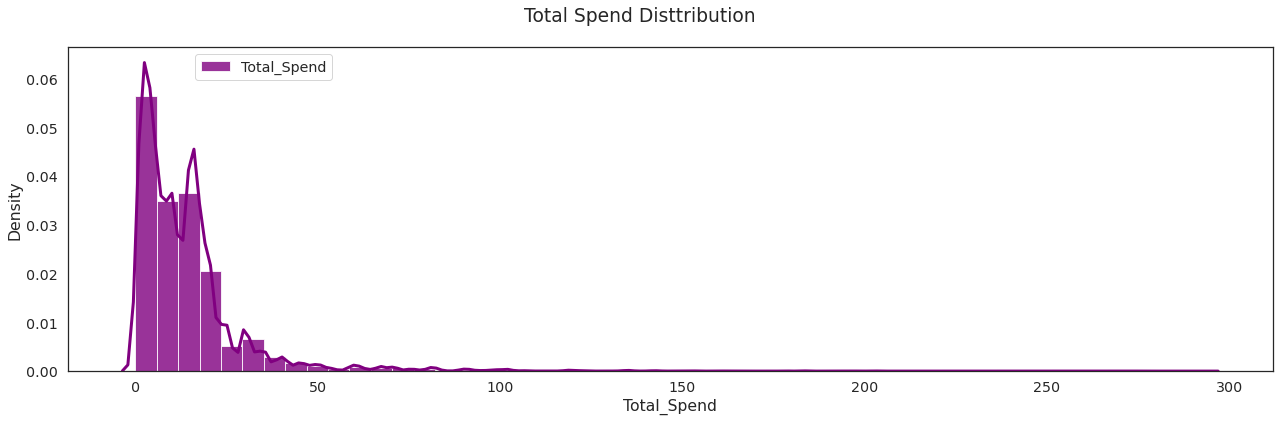

In [33]:
sns.set(font_scale=1.3) 
sns.set_style("white")
kwargs = dict(hist_kws={'alpha':.8}, kde_kws={'linewidth':3})

fig, axes = plt.subplots(figsize=(18, 6))
fig.suptitle('Total Spend Disttribution')
plot1= sns.distplot(df_new['Total_Spend'] , color="Purple", label="Total_Spend" , **kwargs)
plot1.legend( loc = 2, bbox_to_anchor = (0.1,1))
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
plt.rc('patch', edgecolor = 'dimgray', linewidth=1)
fig.tight_layout() 
plt.show()

### No cancelled transaction after outlier treatment

In [34]:
print('Number of cancelled transactions:', len([ i for i  in df_new['InvoiceNo'] if str(i).startswith('C')]))

Number of cancelled transactions: 0


### Feature engineering

In [35]:
df_new['InvoiceDate'] = pd.to_datetime(df_new['InvoiceDate'])
df_new['InvoiceDay'] = df_new['InvoiceDate'].dt.date
customer_data = df_new.groupby('CustomerID')['InvoiceDay'].max().reset_index()
most_recent_date = df_new['InvoiceDay'].max()
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [36]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12347,2
1,12348,248
2,12349,18
3,12350,310
4,12352,36


In [37]:
total_transactions = df_new.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)
total_products_purchased = df_new.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12347,2,7,2151
1,12348,248,3,140
2,12349,18,1,619
3,12350,310,1,196
4,12352,36,7,502


In [38]:

total_spend = df_new.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12347,2,7,2151,3743.43,534.775714
1,12348,248,3,140,90.20,30.066667
2,12349,18,1,619,1287.15,1287.150000
3,12350,310,1,196,294.40,294.400000
4,12352,36,7,502,1147.44,163.920000


In [39]:
unique_products_purchased = df_new.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12347,2,7,2151,3743.43,534.775714,100
1,12348,248,3,140,90.20,30.066667,6
2,12349,18,1,619,1287.15,1287.150000,66
3,12350,310,1,196,294.40,294.400000,16
4,12352,36,7,502,1147.44,163.920000,50


In [40]:
df_new['Day_Of_Week'] = df_new['InvoiceDate'].dt.dayofweek
df_new['Hour'] = df_new['InvoiceDate'].dt.hour

days_between_purchases = df_new.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)


favorite_shopping_day = df_new.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_shopping_hour = df_new.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]


customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')


customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12347,2,7,2151,3743.43,534.775714,100,2.109827,1,14
1,12348,248,3,140,90.20,30.066667,6,22.000000,3,19
2,12349,18,1,619,1287.15,1287.150000,66,0.000000,0,9
3,12350,310,1,196,294.40,294.400000,16,0.000000,2,16
4,12352,36,7,502,1147.44,163.920000,50,3.939394,1,14


In [41]:
customer_country = df_new.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

In [42]:
df_new['Year'] = df_new['InvoiceDate'].dt.year
df_new['Month'] = df_new['InvoiceDate'].dt.month

monthly_spending = df_new.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
  
    else:
        return 0

spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347,2,7,2151,3743.43,534.775714,100,2.109827,1,14,534.775714,298.507941,3.109643
1,12348,248,3,140,90.20,30.066667,6,22.000000,3,19,30.066667,19.760904,-17.900000
2,12349,18,1,619,1287.15,1287.150000,66,0.000000,0,9,1287.150000,0.000000,0.000000
3,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,294.400000,0.000000,0.000000
4,12352,36,7,502,1147.44,163.920000,50,3.939394,1,14,286.860000,110.203888,-3.252000


In [43]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()

### Feature correlation heatmap, the darker the color, the higher the correlation

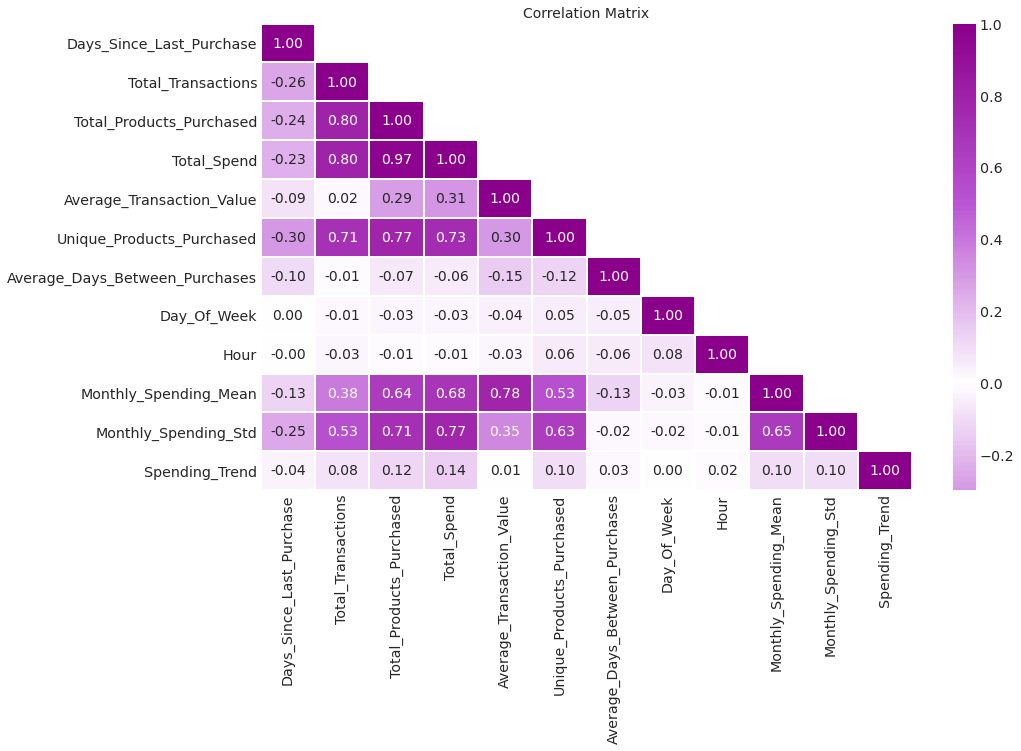

In [44]:
sns.set_style('whitegrid')
corr = customer_data.drop(columns=['CustomerID']).corr()
colors = ['#8b008b', '#ba55d3', 'white', '#ba55d3', '#8b008b']
my_cmap = LinearSegmentedColormap.from_list('custom_blue',colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(13, 8))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [45]:
from collections import defaultdict

item_customers= defaultdict(list)
customer_items= defaultdict(list)

for i, row in df_new.iterrows():
    
    customer_items[str(row['CustomerID']) ].append(str(row['StockCode']))
    item_customers[str(row['StockCode'])].append(str(row['CustomerID']))

### Customer specific features

In [46]:
cols=list(customer_data.columns)
cols.remove('CustomerID')

for i in cols:
    customer_data[i] = customer_data[i] /customer_data[i].abs().max() 

customer_data.head(5) 

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347,0.005362,0.035,0.039864,0.03906,0.128941,0.060459,0.008274,0.166667,0.7,0.067545,0.046081,0.00148
1,12348,0.664879,0.015,0.002595,0.000941,0.007249,0.003628,0.086275,0.5,0.95,0.003798,0.003051,-0.00852
2,12349,0.048257,0.005,0.011472,0.013431,0.310349,0.039903,0.0,0.0,0.45,0.162574,0.0,0.0
3,12350,0.831099,0.005,0.003632,0.003072,0.070984,0.009674,0.0,0.333333,0.8,0.037184,0.0,0.0
4,12352,0.096515,0.035,0.009303,0.011973,0.039523,0.03023,0.015449,0.166667,0.7,0.036232,0.017012,-0.001548


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=Purple>Text to Vector</font></h3>
    
Here we perform two tasks:

   - **Text cleaning by regular expressions:** We clean product descriptions by removing digits, punctuations, stop words, non-english words and special characters.
    
    
   - **Mapping Text into Vectors:** We apply word2vec and TF-IDF.

In [47]:
df_customer = df_new.groupby(['CustomerID', 'Description']).size().reset_index(name= "count")

customer_text= defaultdict(list)

for i, row in df_customer.iterrows():
    
     split_list= row['Description'].split()
    
     for w in split_list:
    
        if len(w)>2:  # words with more than 2 charaters
            
            customer_text[row['CustomerID'] ].append(w)  
        else:
            continue

In [48]:
import pandas as pd
 
df_txt = pd.DataFrame()
df_txt['Dense_Description'] = [customer_text[CustId] for CustId  in customer_text]
df_txt['CustomerID'] = [CustId for CustId  in customer_text]    

In [49]:
print(len(customer_data), len(customer_text))

4159 4210


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(list_txt):

    text= ' '.join(list_txt)
    
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    
    #text = re.sub('-', ' ', text)
    #text = " ".join([word for word in text.split() # remove stop words
                  #if word not in stopwords.words('english')
                  #or word in ['not', 'can']])
    # Remove trailing whitespace
    
    text = re.sub(r'\s+', ' ', text).strip()
    text= re.sub(r'[0-9]+', '',text)
    
    return text

df_txt["tidy_Description"] = df_txt["Dense_Description"].apply(lambda x: clean_text(x))

df_txt[["CustomerID", "tidy_Description", "Dense_Description"]].head(10)

,CustomerID,tidy_Description,Dense_Description
0,12347,dog picture playing cards sheet cat stickers s...,"[DOG, PICTURE, PLAYING, CARDS, SHEET, CAT, STI..."
1,12348,cake cases vintage christmas teatime fairy cak...,"[CAKE, CASES, VINTAGE, CHRISTMAS, TEATIME, FAI..."
2,12349,dolly pegs retrospot black blue polkadot umbre...,"[DOLLY, PEGS, RETROSPOT, BLACK/BLUE, POLKADOT,..."
3,12350,traditional spinning tops bathroom metal sign ...,"[TRADITIONAL, SPINNING, TOPS, BATHROOM, METAL,..."
4,12352,antique glass pedestal bowl baking set piece r...,"[ANTIQUE, GLASS, PEDESTAL, BOWL, BAKING, SET, ..."
5,12353,ceramic cake bowl hanging cakes mini cake stan...,"[CERAMIC, CAKE, BOWL, HANGING, CAKES, MINI, CA..."
6,12354,assorted colour mini cases baking set piece re...,"[ASSORTED, COLOUR, MINI, CASES, BAKING, SET, P..."
7,12355,green regency teacup and saucer grow flytrap s...,"[GREEN, REGENCY, TEACUP, AND, SAUCER, GROW, FL..."
8,12356,cake cases dolly girl design baking mould choc...,"[CAKE, CASES, DOLLY, GIRL, DESIGN, BAKING, MOU..."
9,12357,bendy skull straws red white bendy straws pi...,"[200, BENDY, SKULL, STRAWS, 200, RED, WHITE, B..."


In [51]:
df_txt['CustomerID'] = df_txt['CustomerID'].astype(str)

df_txtual= df_txt.drop(['Dense_Description'], axis=1)

df_txtual.head()

,CustomerID,tidy_Description
0,12347,dog picture playing cards sheet cat stickers s...
1,12348,cake cases vintage christmas teatime fairy cak...
2,12349,dolly pegs retrospot black blue polkadot umbre...
3,12350,traditional spinning tops bathroom metal sign ...
4,12352,antique glass pedestal bowl baking set piece r...


### Word frequency

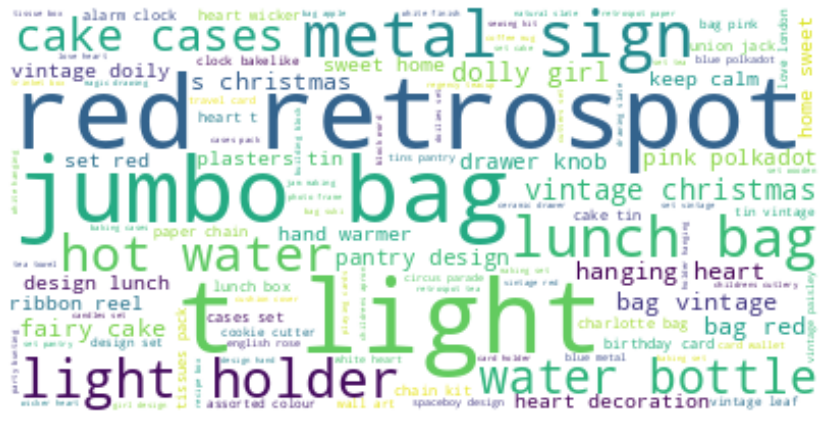

In [52]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = " ".join([ x for x in df_txtual["tidy_Description"].values ])

plt.rcParams['figure.figsize'] = (13, 13)

wordcloud = WordCloud(max_words=1000000,background_color="white").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
df_vec = pd.merge(customer_data, df_txtual, on='CustomerID')

df_vec.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,tidy_Description
0,12347,0.005362,0.035,0.039864,0.03906,0.128941,0.060459,0.008274,0.166667,0.7,0.067545,0.046081,0.00148,dog picture playing cards sheet cat stickers s...
1,12348,0.664879,0.015,0.002595,0.000941,0.007249,0.003628,0.086275,0.5,0.95,0.003798,0.003051,-0.00852,cake cases vintage christmas teatime fairy cak...
2,12349,0.048257,0.005,0.011472,0.013431,0.310349,0.039903,0.0,0.0,0.45,0.162574,0.0,0.0,dolly pegs retrospot black blue polkadot umbre...
3,12350,0.831099,0.005,0.003632,0.003072,0.070984,0.009674,0.0,0.333333,0.8,0.037184,0.0,0.0,traditional spinning tops bathroom metal sign ...
4,12352,0.096515,0.035,0.009303,0.011973,0.039523,0.03023,0.015449,0.166667,0.7,0.036232,0.017012,-0.001548,antique glass pedestal bowl baking set piece r...


In [54]:
df_vec.shape

(4159, 14)

In [55]:
Cust2id ={}
id2Cust ={}

for i, st in enumerate(list(set(df_vec["CustomerID"].values))):
    Cust2id[st]=i 
    id2Cust[i]=st    

### TF-IDF

In [56]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=500, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_vec["tidy_Description"])
tfidf.shape

(4159, 500)

### Word2vec model is already learned and saved 

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

tokenized_text =  [x.split() for x in df_vec['tidy_Description'].values]

model_v = gensim.models.Word2Vec(
            tokenized_text,
            vector_size=300, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_v.train(tokenized_text, total_examples= df_vec['tidy_Description'].shape[0], epochs=20)

(15455940, 20109600)

In [58]:
from gensim.models import KeyedVectors

model_v.wv.save("word2vec_model2.wordvectors")

model_w2v = KeyedVectors.load("word2vec_model2.wordvectors", mmap='r')

In [59]:
def word_vector(tokens, size):
    
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
            
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
            
    if count != 0:
        vec /= count
    return vec

In [60]:
wordvec_arrays = np.zeros((len(tokenized_text), 300)) 

for i in range(len(tokenized_text)):
    
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 300)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape


(4159, 300)

In [61]:
tfidf_arr= tfidf.todense()  #bow_arr= bow.todense()

print(tfidf_arr.shape)

(4159, 500)


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=Purple>Building Final Embeddings & Vector Quality Assessment </font></h3>
    
Here we provide some visual explorations over learned vectors:

   - **TSNE Customer Vector Visualization:** This visualization helps to observe the diffrence of word2vec and TF-IDF in 2D space
    
    
   - **K-means Clustering:** with more accurate clustering we can decide on quality of vector embeddings. The number of clusters is assigned optimaly with Elbow check method. Silhouette score score measures within-cluster similarity and out-of-cluster discrimination. 

### Concatenating  behavior features with learnt embeddings for each customer.

In [62]:
w2v_matrix=[]
tf_matrix=[]

for i, row in df_vec.iterrows(): 
    
    # row['Day_Of_Week'] row['Hour'],row['Monthly_Spending_Std'], row['Average_Transaction_Value']
    #row['Days_Since_Last_Purchase'], , row['Spending_Trend' ], row['Monthly_Spending_Mean']
    
    feat_vec= [row['Total_Transactions'], row['Days_Since_Last_Purchase'],  row['Monthly_Spending_Mean'],
       row['Total_Products_Purchased'], row['Total_Spend'], row['Day_Of_Week'], row['Hour'],
       row['Unique_Products_Purchased'], row['Average_Days_Between_Purchases'] ]
    
    w2v_matrix.append( feat_vec+list(np.array(wordvec_arrays[i])) ) #
    tf_matrix.append( feat_vec+ np.array(tfidf_arr[i]).tolist()[0])


w2vec_matrix=np.array(w2v_matrix)    
tfidf_matrix =np.array(tf_matrix) 

print(w2vec_matrix.shape)
print(tfidf_matrix.shape)

(4159, 309)
(4159, 509)


In [63]:
df_w2v = pd.DataFrame()

df_w2v['CustomerID'] = [int(id2Cust[i]) for i in range(w2vec_matrix.shape[0])] 

for i in range(w2vec_matrix.shape[1]):
    
 
    df_w2v['feat_'+str(i)] = w2vec_matrix[:,i]
    
            
df_w2v.head(5)

,CustomerID,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_299,feat_300,feat_301,feat_302,feat_303,feat_304,feat_305,feat_306,feat_307,feat_308
0,15830,0.035,0.005362,0.067545,0.039864,0.039060,0.166667,0.70,0.060459,0.008274,...,0.061192,0.175152,0.066239,0.020987,0.000115,-0.009175,-0.166703,0.091429,-0.009475,0.150644
1,17181,0.015,0.664879,0.003798,0.002595,0.000941,0.500000,0.95,0.003628,0.086275,...,-0.024016,0.064248,0.069046,-0.012842,-0.002694,-0.034257,-0.201980,0.137294,0.013485,0.095306
2,12384,0.005,0.048257,0.162574,0.011472,0.013431,0.000000,0.45,0.039903,0.000000,...,0.103587,0.120265,0.100833,0.030749,0.002941,-0.004387,-0.127758,0.109680,0.032131,0.144704
3,12386,0.005,0.831099,0.037184,0.003632,0.003072,0.333333,0.80,0.009674,0.000000,...,0.059027,0.201203,0.064604,0.148023,-0.106763,0.131740,-0.218963,0.066122,0.065519,0.202681
4,16048,0.035,0.096515,0.036232,0.009303,0.011973,0.166667,0.70,0.030230,0.015449,...,0.105164,0.096965,0.092564,0.058707,0.006496,0.016863,-0.130504,0.105414,0.056324,0.132713


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix_wv= cosine_similarity(w2vec_matrix)
cosine_matrix_tf= cosine_similarity(tfidf_matrix)

print(cosine_matrix_wv.shape)
print(cosine_matrix_tf.shape)

(4159, 4159)
(4159, 4159)


In [65]:
def sim_customers(title=None, cosine_sim=None, k=5):
    
    idx = Cust2id[title]

    sim_scores1 = list(enumerate(cosine_sim[idx]))
    sim_scores2 = sorted(sim_scores1, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores2[1:k+1]
    p_indices = [i[0] for i in sim_scores]
    cust_list=[id2Cust[i] for i in p_indices]
    
    unsim_scores = sim_scores2[-k:]
    u_indices = [i[0] for i in unsim_scores]
    
    full_idx= p_indices+u_indices
    
    return cust_list, full_idx

In [66]:
idx_list_tf=[]
idx_list_wv=[]
import random 

custs= random.sample(list(df_vec['CustomerID'].values), 50)

for cust in custs:
    
    sim_products_wv, ids_vw= sim_customers(cust, w2vec_matrix,20)
    idx_list_wv.extend(ids_vw)
    sim_products_tf, ids_tf = sim_customers(cust, tfidf_matrix, 20)
    idx_list_tf.extend(ids_tf)

In [67]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

def tsne_plot(vec_matrix, idxs, title=None):
    
    labels = []
    tokens = []

    for idx in idxs:
        
        tokens.append(vec_matrix[idx])
        labels.append(id2Cust[idx])
    
    tsne_model = TSNE(perplexity=len(tokens)-1, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 10)) 
    plt.title(title, fontsize="18")
    plt.rcParams["patch.force_edgecolor"] = True
    #plt.style.use('fivethirtyeight')
    #plt.rc('patch', edgecolor = 'dimgray', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    
    plt.show()

### Word2vec and TF-IDF visualizations on the same set of customers are different

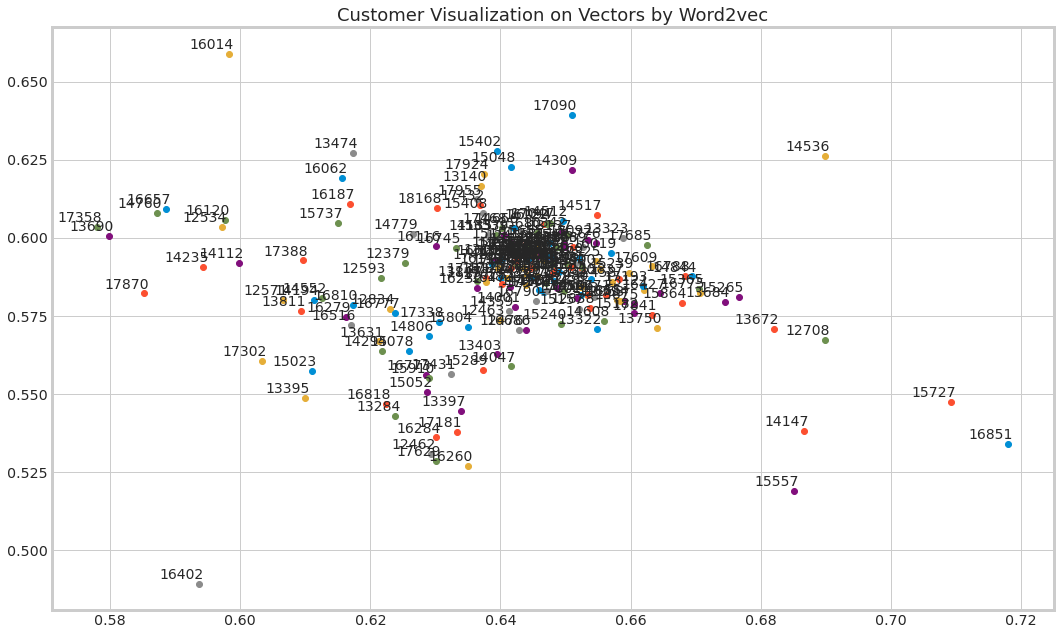

In [68]:
tsne_plot(w2vec_matrix, list(set(idx_list_wv)), "Customer Visualization on Vectors by Word2vec")

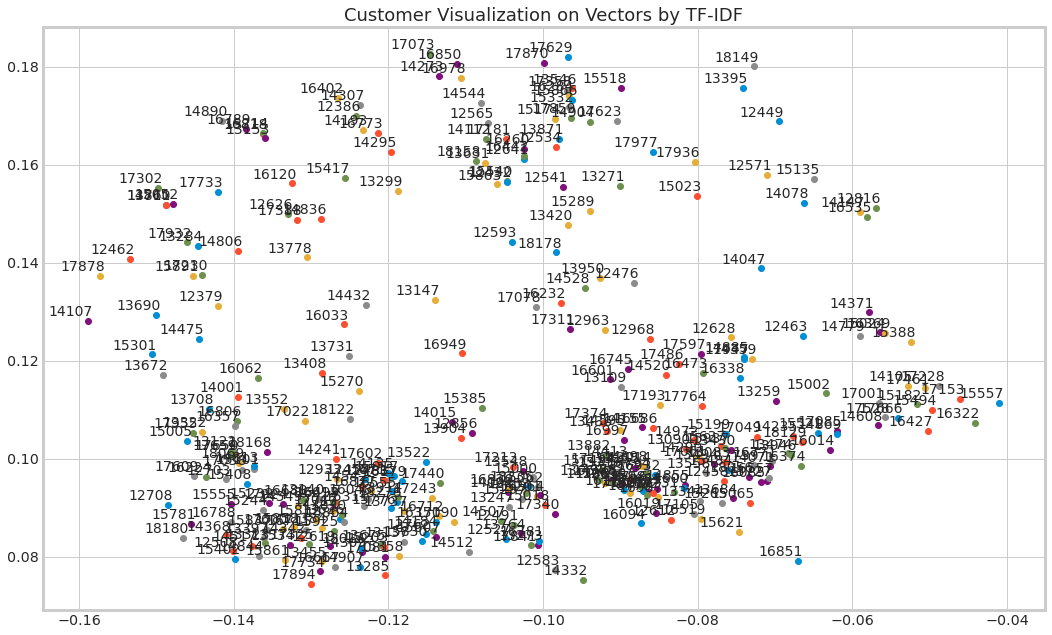

In [69]:
tsne_plot(tfidf_matrix, list(set(idx_list_tf)), "Customer Visualization on Vectors by TF-IDF")

### Elbow check finds the optimal number of clusters

In [70]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

def Elbow_check(matrix=None):
    
    sns.set(style='darkgrid', rc={'axes.facecolor': '#f0f0f0'})

    sns.set_palette(['#ff6200'])

    # Instantiate the clustering model with the specified parameters
    km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

    # Create a figure and axis with the desired size
    fig, ax = plt.subplots(figsize=(12, 5))

    # Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
    visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

    visualizer.fit(matrix)
    visualizer.show()

### Optimal k  on TF-IDF vectors 

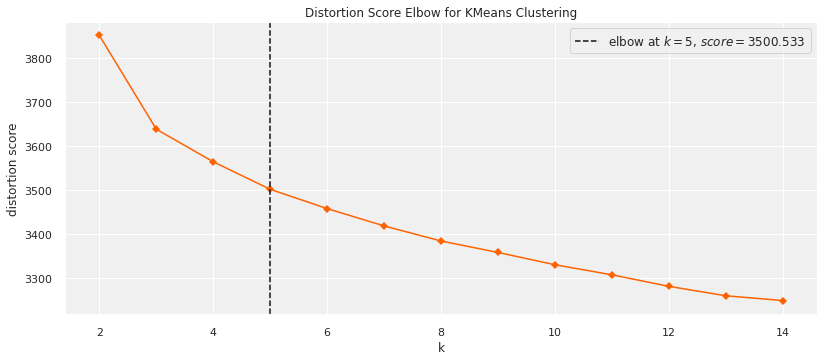

In [71]:
Elbow_check(tfidf_matrix)

### Optimal k on Word2vec vectors

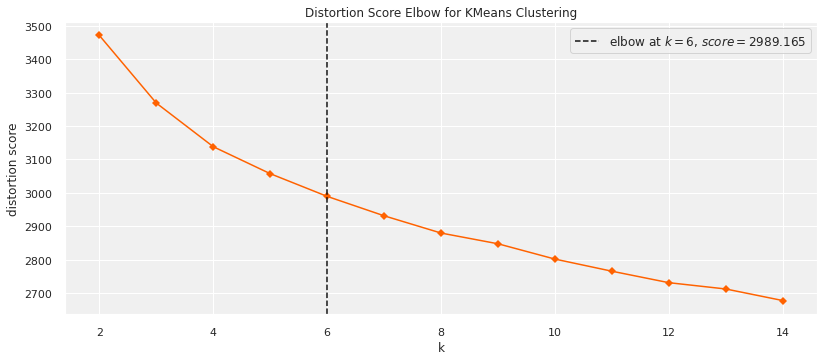

In [72]:
Elbow_check(w2vec_matrix)

In [73]:
def KMEANS(matrix=None, k=5, title=None):

    kmeans = KMeans(init='k-means++', n_clusters =k, n_init=30, random_state=0) 
    kmeans.fit(matrix)
    clusters= kmeans.predict(matrix)

    tsne = TSNE(n_components=2)
    proj = tsne.fit_transform(matrix)
    plt.figure(figsize=(13,8))
    plt.scatter(proj[:,0], proj[:,1], c=clusters)
    plt.title(title, fontsize="16")
    return clusters
        

### Clustering on Word2vec vectors provides more accurate split on data with a higher Silhouette score 

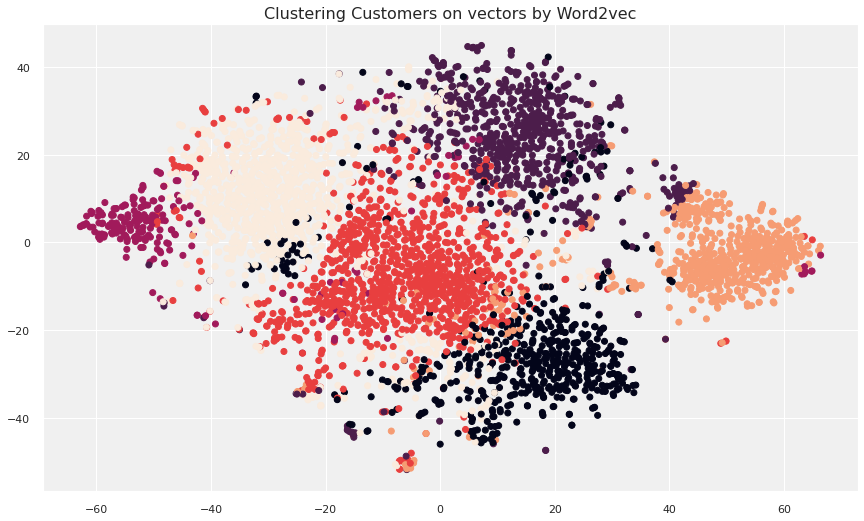

In [74]:
clusters_vw= KMEANS(w2vec_matrix, 6, "Clustering Customers on vectors by Word2vec")

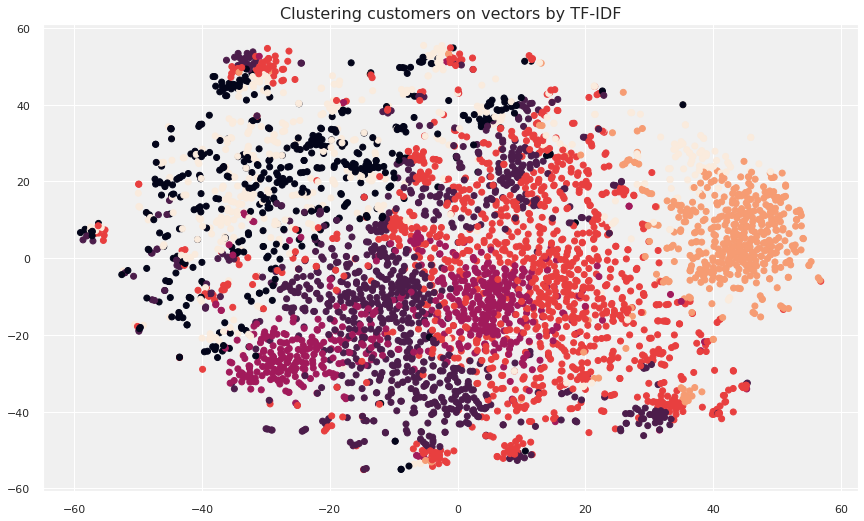

In [75]:
clusters_tf= KMEANS(tfidf_matrix, 6, "Clustering customers on vectors by TF-IDF")

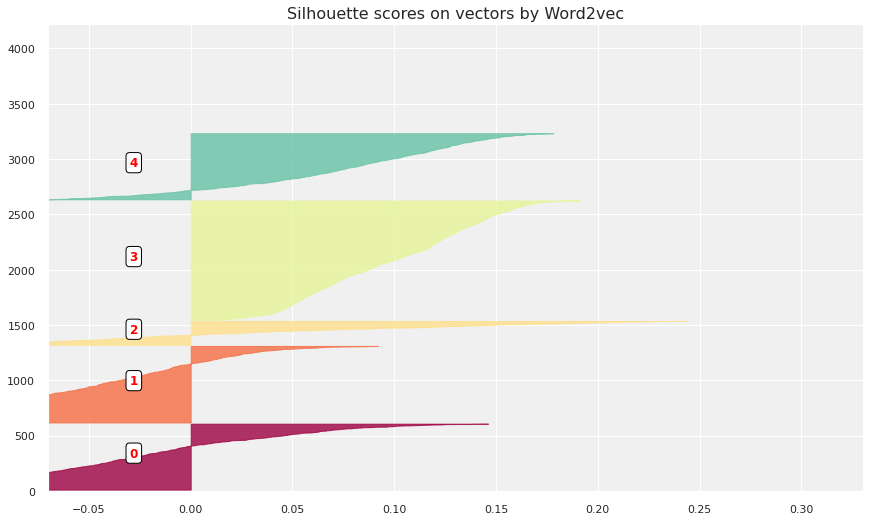

In [76]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters, title):
   
    #
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(13, 8)
    plt.title("Silhouette scores on vectors by %s"%title, fontsize="16")
    
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 
        

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(w2vec_matrix, clusters_vw)

graph_component_silhouette(5, [-0.07, 0.33], len(w2vec_matrix), 
                                                    sample_silhouette_values, clusters_vw, 'Word2vec')        

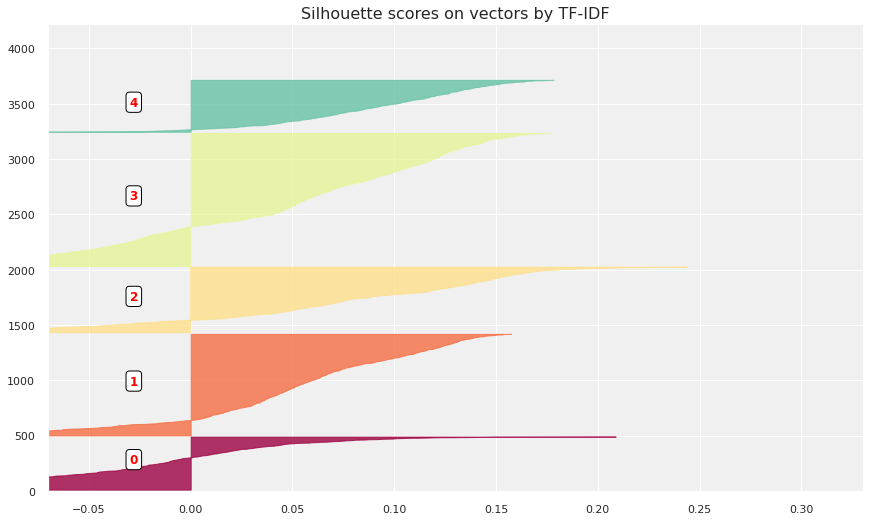

In [77]:
graph_component_silhouette(5, [-0.07, 0.33], len(tfidf_matrix), 
                                                     sample_silhouette_values, clusters_tf, 'TF-IDF')   

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h2 align="left"><font color=Purple>Learning to Rank </font></h2>

<br> 

   
- **Model:**  We propose to use a pairwise learning to rank model which  essentially tries to detect what products are relevant to the current customer, and which are not. The target for learning to rank is a relevance score, which tells us how relevant the customer is to the current product.For this purpose we use XGBRanker with default objective is rank:ndcg based on the LambdaMART algorithm. LambdaMART (Multiple Additive Regression Trees) is the boosted tree version of LambdaRank, which is based on RankNet. LambdaMART is a technique where ranking is transformed into a pairwise classification or regression and finally generate a relevance score in the list. The objectives are rank:ndcg, rank:map and rank:pairwise.
   
    
- **Evaluation:** We measure the quality of our ranking algorithm by Normalized Discounted Cumulative Gain (NDCG).  NDCG is the enhanced version of CG (Cumulative Gain). In CG, recommending an order does not matter. If your results contain relevant items in any order, this will give you a higher value, indicating our predictions are good.  
 

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score, make_scorer
import matplotlib.pyplot as plt
import random
from warnings import filterwarnings
filterwarnings('ignore')


In [79]:
df_new[['CustomerID', 'StockCode', 'Quantity']].head(5)

,CustomerID,StockCode,Quantity
0,17850,85123A,6
1,17850,71053,6
2,17850,84406B,8
3,17850,84029G,6
4,17850,84029E,6


### How many times a product was purchased  by a customer

In [80]:
df_rating = df_new.groupby(['CustomerID', 'StockCode' ])['Quantity'].sum().reset_index(name='User_Rank')

df_rating.head(5)

,CustomerID,StockCode,User_Rank
0,12347,16008,24
1,12347,17021,36
2,12347,20665,6
3,12347,20719,40
4,12347,20780,12


In [81]:
cust2id ={}

for i, st in enumerate(list(set(df_rating["CustomerID"].values))):
    cust2id[st]=i 
     
df_rating["CustomerID"] = df_rating["CustomerID"].astype(int)
df_vec["CustomerID"] = df_vec["CustomerID"].astype(int)

df_rating["Q_ID"] = [cust2id[st] for st in df_rating["CustomerID"].values]
#df_rating["Country"] = [Cust2Country[st] for st in df_rating["CustomerID"].values]
 
df_rating.head(8)

,CustomerID,StockCode,User_Rank,Q_ID
0,12347,16008,24,1326
1,12347,17021,36,1326
2,12347,20665,6,1326
3,12347,20719,40,1326
4,12347,20780,12,1326
5,12347,20782,6,1326
6,12347,20966,10,1326
7,12347,21035,6,1326


In [82]:
df_rating["Q_ID"].describe()

count    242734.000000
mean       2106.607237
std        1213.693870
min           0.000000
25%        1020.000000
50%        2126.000000
75%        3156.000000
max        4209.000000
Name: Q_ID, dtype: float64

### Cuting  off some of data due to desktop computation limits 

In [83]:
df_small = df_rating[df_rating["CustomerID"]<14000 ]

df_small

,CustomerID,StockCode,User_Rank,Q_ID
0,12347,16008,24,1326
1,12347,17021,36,1326
2,12347,20665,6,1326
3,12347,20719,40,1326
4,12347,20780,12,1326
...,...,...,...,...
64017,13999,85053,12,2514
64018,13999,85054,12,2514
64019,13999,85059,8,2514
64020,13999,85099B,50,2514


### Full feature set (customer specific features and Word2vec vectors)

In [84]:
df_merge2 = pd.merge(df_small, df_w2v, on='CustomerID')
df_merge2.head(8)

,CustomerID,StockCode,User_Rank,Q_ID,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_299,feat_300,feat_301,feat_302,feat_303,feat_304,feat_305,feat_306,feat_307,feat_308
0,12347,16008,24,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
1,12347,17021,36,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
2,12347,20665,6,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
3,12347,20719,40,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
4,12347,20780,12,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
5,12347,20782,6,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
6,12347,20966,10,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
7,12347,21035,6,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831


In [85]:
df_rank= df_merge2.drop(['CustomerID', 'StockCode'], axis=1) #

df_rank.head(5)

,User_Rank,Q_ID,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_299,feat_300,feat_301,feat_302,feat_303,feat_304,feat_305,feat_306,feat_307,feat_308
0,24,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,0.6,0.029625,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
1,36,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,0.6,0.029625,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
2,6,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,0.6,0.029625,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
3,40,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,0.6,0.029625,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831
4,12,1326,0.005,0.986595,0.028602,0.001724,0.002363,0.0,0.6,0.029625,...,0.173326,0.157665,0.13714,0.014273,0.021693,0.047206,-0.11102,0.135983,-0.014494,0.147831


In [86]:
# dividing data into k samples each of which having a unique Q_ID

def population_sampler(population, k):
    random.seed(123)
    random.shuffle(population)
    return [population[i::k] for i in range(k)]

print('This is one fold with unique Q_IDs','\n')
print(df_rank.Q_ID.unique() [1::5])

This is one fold with unique Q_IDs 

[1327 1332 1337 1342 1347 1352 1357 1362 1367 1372 1377 1382 1387 1392
 1397 1402 1407 1412 1417 1422 1427 1432 1437 1442 1448 1453 1458 1463
 1468 1473 1478 1483 1488 1493 1498 1503 1508 1513 1518 1523 1528 1533
 1538 1543 1548 1553 1558 1563 1568 1573 1578 1583 1588 1593 1598 1603
 1608 1613 1618 1623 1628 1633 1638 1643 1648 1653 1658 1663 1668 1673
 1678 1683 1688 1693 1698 1703 1708 1713 1718 1723 1729 1734 1739 1744
 1749 1754 1759 1764 1769 1775 1780 1785 1790 1795 1800 1805 1810 1815
 1820 1825 1830 1835 1840 1845 1850 1855 1860 1865 1870 1875 1880 1886
 1891 1897 1902 1907 1912 1917 1922 1927 1932 1937 1942 1949 1954 1959
 1966 1971 1976 1981 1986 1991 1996 2001 2006 2011 2016 2022 2028 2033
 2038 2043 2048 2053 2058 2063 2068 2073 2078 2083 2088 2093 2098 2103
 2108 2113 2118 2123 2128 2133 2138 2143 2148 2153 2159 2164 2169 2174
 2179 2184 2189 2194 2199 2204 2209 2214 2219 2224 2229 2234 2239 2244
 2249 2254 2259 2264 2269 2274 2279 2284

In [87]:
# getting X, y and group size for each Q_ID, fold is list of Q_IDs

def splitXy(df, fold):
    train = df[~(df.Q_ID.isin(fold))]
    test = df[df.Q_ID.isin(fold)]
    groups = train.groupby('Q_ID').size().values
    X_train = train.drop(['Q_ID','User_Rank'], axis=1)
    X_test = test.drop(['User_Rank'], axis=1)
    y_train = train.User_Rank
    y_test = test.User_Rank

    return X_train, X_test, y_train, y_test, groups

In [88]:
# fitting the model: the hyperparameters are not tunned here.

def fit_model(X_train, y_train, groups):
    
    model = XGBRanker(  
    booster='gbtree',
    objective='rank:ndcg',  #rank:pairwise  rank:ndcg
    random_state=123,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=110,
    subsample=0.75
    )

    return model.fit(X_train, y_train, group=groups, verbose=False)

### Making predictions and computing  NDCG  score

In [89]:
def predictions(model, X_test, y_test):
    
    temp = pd.concat([X_test, y_test], axis=1)[['Q_ID','User_Rank']]
    
    # making the predictions
    temp['prediction'] = model.predict(X_test.drop('Q_ID', axis=1))
    
    # getting lists of scores and predicted values for each Q_ID
    temp = temp.groupby('Q_ID').agg({'User_Rank':list, 'prediction':list}).reset_index()
    return temp

In [90]:
# running altogether

def runCV(df):
    
    # getting the folds
    folds = population_sampler(df.Q_ID.unique(), k=5)
    
    # instanciating an empty dataframe
    results = pd.DataFrame(columns={'Q_ID','User_Rank','prediction'}) #,'NDCG'
    
    for i, fold in enumerate(folds):

        X_train, X_test, y_train, y_test, groups = splitXy(df, fold)
        model = fit_model(X_train, y_train, groups)
        temp = predictions(model, X_test, y_test)

        #print ('Fold-%s NDCG Score: %.2f'%(i+1,temp.NDCG.mean()))
        
        # putting all results from all folds in the dataframe
        results = pd.concat([results, temp], axis=0).sort_values('Q_ID').reset_index(drop=True)
    
    
    return results

In [91]:
results = runCV(df_rank)

In [92]:
results.head(10)

,User_Rank,Q_ID,prediction
0,"[24, 36, 6, 40, 12, 6, 10, 6, 12, 30, 10, 12, ...",1326,"[0.2213650345802307, 0.2213650345802307, 0.221..."
1,"[24, 24, 24, 20, 24, 24]",1327,"[0.5744362473487854, 0.5744362473487854, 0.574..."
2,"[6, 6, 12, 16, 36, 36, 3, 6, 3, 6, 6, 6, 24, 1...",1328,"[0.6698571443557739, 0.6698571443557739, 0.669..."
3,"[12, 12, 12, 12, 12, 12, 12, 12, 24, 12, 12, 1...",1329,"[0.7318711876869202, 0.7318711876869202, 0.731..."
4,"[12, 8, 6, 12, 12, 12, 3, 6, 6, 2, 24, 12, 3, ...",1330,"[0.3408178389072418, 0.3408178389072418, 0.340..."
5,"[8, 6]",1331,"[0.4830874502658844, 0.4830874502658844]"
6,"[8, 8, 8, 10, 2, 2, 12, 8, 24, 32, 32, 24, 32,...",1332,"[0.15267716348171234, 0.15267716348171234, 0.1..."
7,"[8, 24, 6, 6, 6, 6, 6, 6, 12]",1333,"[0.4020274877548218, 0.4020274877548218, 0.402..."
8,"[8, 15, 6, 10, 24, 24, 12, 24, 24, 12, 32, 24,...",1334,"[-0.08518065512180328, -0.08518065512180328, -..."
9,"[9, 3, 16, 9, 12, 12, 12, 12, 16, 30, 8, 12, 1...",1335,"[0.6092435717582703, 0.6092435717582703, 0.609..."


Predictions contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters.


### An acceptable NDCG score on a part of dataset, it can be improved involving more customers 

In [93]:
collect_nag, user_collects=[],[]
    
for true, pred, st in zip(results ['User_Rank'], results ['prediction'], results['Q_ID']):   
    
    if len(true)>1 :  
    
        collect_nag.append( ndcg_score([true],[pred] ) )
             
        user_collects.append(st)
    
print ('Total NDCG Score : %.2f'%np.mean(collect_nag))

Total NDCG Score : 0.78


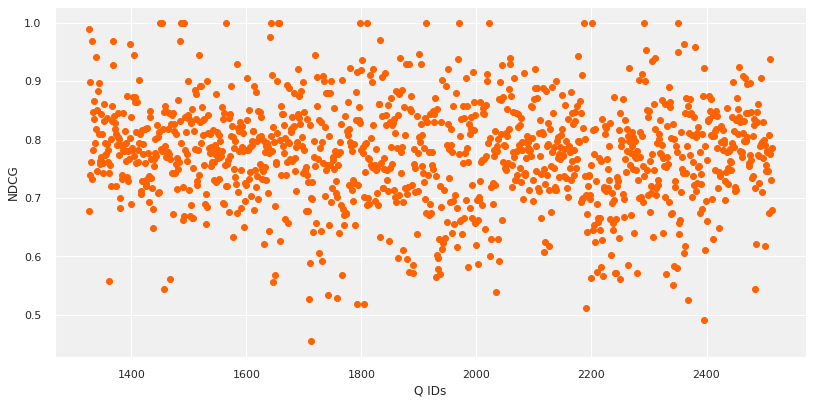

In [94]:
plt.figure(figsize=(12, 6))
plt.scatter(user_collects, collect_nag)
plt.xlabel("Q IDs")
plt.ylabel("NDCG")
plt.show()
